# Import Libaries

In [ ]:
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as func

from six.moves import urllib

import time

# Download the MNIST Dataset

In [ ]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

dataset = MNIST(root='data/', 
                train=True, 
                download=True, 
                transform=ToTensor())

test_dataset = MNIST(root='data/',
                    train=False,
                    download=True,
                    transform=ToTensor())

# Split Dataset into Training and Validation Set

In [ ]:
print(len(dataset))
val_precentage = 0.2 #take 20% of the training set to be the validation set
val_size = int(len(dataset)*val_precentage)
train_size = int(len(dataset)-val_size)

train_set, val_set = random_split(dataset, [train_size, val_size])
print(len(train_set))
print(len(val_set))

# Create Dataloaders

In [ ]:
batch_size = 100

train_loader = DataLoader(train_set, batch_size, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_set, batch_size, num_workers = 2)

# Use GPU if available and CPU if not

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

In [ ]:
input_size = 28*28
output_size = 10

hidden_size1 = 32
hidden_size2 = 64
hidden_size3 = 128

# Model_1: Fully Connected Neural Network with 1 Hidden Layer

In [ ]:
class Fully_Connected_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            #input layer to hidden layer
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            
            #hidden layer to output layer
            nn.Linear(hidden_size1, output_size),
            nn.ReLU()
        )
        self.acclist = []
        
    def forward(self, xb):
        xb =self.flatten(xb)
        out = self.linear_relu_stack(xb)
        return out
    
model_1 = Fully_Connected_1().to(device)
print(model_1)

In [ ]:
torch.save(model_1, 'FC_1HL.pth')

# Model_2: Fully Connected Neural Network with 3 Hidden Layers

In [ ]:
class Fully_Connected_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, output_size),
            nn.ReLU()
        )
        self.acclist = []
        
    def forward(self, xb):
        xb =self.flatten(xb)
        out = self.linear_relu_stack(xb)
        return out
    
model_2 = Fully_Connected_2().to(device)
print(model_2)

In [ ]:
torch.save(model_2, 'FC_3HL.pth')

# Model_3: CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #output: 16 x 14 x 14
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #output: 32 x 7 x 7
            
            nn.Flatten(),
            nn.Linear(32*7*7, 10),
            #nn.ReLU(),
            #nn.Linear(1024, 512),
            #nn.ReLU(),
            #nn.Linear(512, 10)  
        )
        self.acclist=[]
        
    def forward(self, xb):
        return self.cnn_layers(xb)
    
model_3 = CNN().to(device)
print(model_3)

In [ ]:
torch.save(model_3, 'CNN.pth')

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train(dataloader, model, loss_fn, lr, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #show real time result when training the batch
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def train2(dataloader, model, loss_fn, lr, opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(), lr)
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #show real time result when training the batch
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def validate(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    val_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    val_loss /= size
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return correct

In [ ]:
def fit(epochs, model, train_dataloader, val_dataloader, loss_fn, lr):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, lr)
        model.acclist.append(validate(val_dataloader, model)*100)
    print("TRAINING COMPLETE")

In [ ]:
def fit2(epochs, model, train_dataloader, val_dataloader, loss_fn, lr):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        train2(train_dataloader, model, loss_fn, lr)
        model.acclist.append(validate(val_dataloader, model)*100)
    print("TRAINING COMPLETE")

# -----------------------------------------------------------------------------------------

# Showing result for model_1

In [ ]:
model_1.acclist.append(validate(val_loader, model_1)*100)
start = time.perf_counter()
result_1 = fit(10, model_1, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

# Apply model_1 on the test dataset

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_1)

# Showing result for model_2

In [ ]:
model_2.acclist.append(validate(val_loader, model_2)*100)
start = time.perf_counter()
result_2 = fit(10, model_2, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

# Apply model_2 on the test dataset

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_2)

# Showing result for model_3

In [ ]:
model_3.acclist.append(validate(val_loader, model_3)*100)
start = time.perf_counter()
result_3 = fit(10, model_3, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

# Applying model_3 on the test dataset

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_3)

# Plotting Accuracy vs Epochs Graph for Comparasion

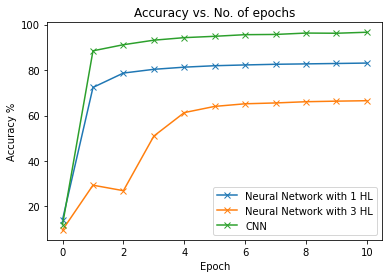

In [80]:
plt.plot(model_1.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_2.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_3.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [ ]:
model_4 = torch.load('FC_1HL.pth')
model_4.acclist.append(validate(val_loader, model_4)*100)
start = time.perf_counter()
result_4 = fit(20, model_4, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_4)

In [ ]:
model_5 = torch.load('FC_3HL.pth')
model_5.acclist.append(validate(val_loader, model_5)*100)
start = time.perf_counter()
result_5 = fit(20, model_5, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds/n")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_5)

In [ ]:
model_6 = torch.load('CNN.pth')
model_6.acclist.append(validate(val_loader, model_6)*100)
start = time.perf_counter()
result_6 = fit(20, model_6, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_6)

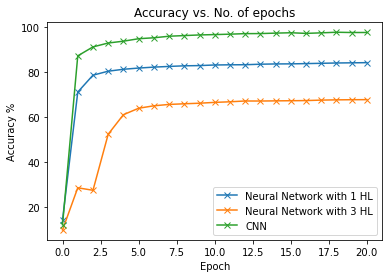

In [87]:
plt.plot(model_4.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_5.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_6.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [ ]:
model_7 = torch.load('FC_1HL.pth')
model_7.acclist.append(validate(val_loader, model_7)*100)
start = time.perf_counter()
result_7 = fit(10, model_7, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_7)

In [ ]:
model_8 = torch.load('FC_3HL.pth')
model_8.acclist.append(validate(val_loader, model_8)*100)
start = time.perf_counter()
result_8 = fit(10, model_8, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_8)

In [ ]:
model_9 = torch.load('CNN.pth')
model_9.acclist.append(validate(val_loader, model_9)*100)
start = time.perf_counter()
result_9 = fit(10, model_9, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_9)

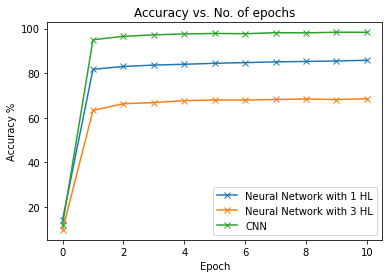

In [86]:
plt.plot(model_7.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_8.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_9.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [54]:
model_10.acclist.clear()

In [55]:
model_10 = torch.load('FC_1HL.pth')
model_10.acclist.append(validate(val_loader, model_10)*100)
start = time.perf_counter()
result_10 = fit(20, model_10, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_10)

Validation Error: 
 Accuracy: 14.2%, Avg loss: 0.023005 

Epoch 1
-------------------------------
loss: 2.299773  [    0/48000]
loss: 1.205482  [10000/48000]
loss: 0.849161  [20000/48000]
loss: 0.710113  [30000/48000]
loss: 0.658533  [40000/48000]
Validation Error: 
 Accuracy: 81.7%, Avg loss: 0.006245 

Epoch 2
-------------------------------
loss: 0.548744  [    0/48000]
loss: 0.418182  [10000/48000]
loss: 0.576693  [20000/48000]
loss: 0.580249  [30000/48000]
loss: 0.366157  [40000/48000]
Validation Error: 
 Accuracy: 83.0%, Avg loss: 0.005395 

Epoch 3
-------------------------------
loss: 0.322376  [    0/48000]
loss: 0.479684  [10000/48000]
loss: 0.461973  [20000/48000]
loss: 0.625007  [30000/48000]
loss: 0.578666  [40000/48000]
Validation Error: 
 Accuracy: 83.6%, Avg loss: 0.005117 

Epoch 4
-------------------------------
loss: 0.407667  [    0/48000]
loss: 0.349150  [10000/48000]
loss: 0.547839  [20000/48000]
loss: 0.520882  [30000/48000]
loss: 0.503020  [40000/48000]
Validati

In [ ]:
model_11 = torch.load('FC_3HL.pth')
model_11.acclist.append(validate(val_loader, model_11)*100)
start = time.perf_counter()
result_11 = fit(20, model_11, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_11)

In [ ]:
model_12 = torch.load('CNN.pth')
model_12.acclist.append(validate(val_loader, model_12)*100)
start = time.perf_counter()
result_12 = fit(20, model_12, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_12)

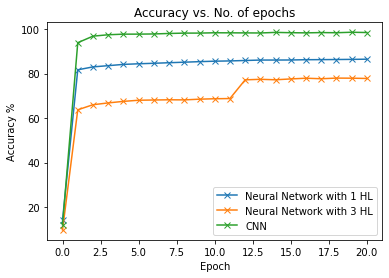

In [56]:
plt.plot(model_10.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_11.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_12.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [44]:
model_13 = torch.load('FC_1HL.pth')
model_13.acclist.append(validate(val_loader, model_13)*100)
start = time.perf_counter()
result_13 = fit(10, model_13, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_13)

Validation Error: 
 Accuracy: 14.2%, Avg loss: 0.023005 

Epoch 1
-------------------------------
loss: 2.298339  [    0/48000]
loss: 0.820978  [10000/48000]
loss: 0.577196  [20000/48000]
loss: 0.769303  [30000/48000]
loss: 0.610424  [40000/48000]
Validation Error: 
 Accuracy: 82.6%, Avg loss: 0.005490 

Epoch 2
-------------------------------
loss: 0.528482  [    0/48000]
loss: 0.555474  [10000/48000]
loss: 0.556422  [20000/48000]
loss: 0.476120  [30000/48000]
loss: 0.442754  [40000/48000]
Validation Error: 
 Accuracy: 84.0%, Avg loss: 0.004912 

Epoch 3
-------------------------------
loss: 0.429465  [    0/48000]
loss: 0.481362  [10000/48000]
loss: 0.423127  [20000/48000]
loss: 0.593246  [30000/48000]
loss: 0.581063  [40000/48000]
Validation Error: 
 Accuracy: 84.7%, Avg loss: 0.004641 

Epoch 4
-------------------------------
loss: 0.389077  [    0/48000]
loss: 0.303361  [10000/48000]
loss: 0.444319  [20000/48000]
loss: 0.512586  [30000/48000]
loss: 0.407900  [40000/48000]
Validati

In [45]:
model_14 = torch.load('FC_3HL.pth')
model_14.acclist.append(validate(val_loader, model_14)*100)
start = time.perf_counter()
result_14 = fit(10, model_14, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_14)

Validation Error: 
 Accuracy: 9.7%, Avg loss: 0.023031 

Epoch 1
-------------------------------
loss: 2.303090  [    0/48000]
loss: 2.077960  [10000/48000]
loss: 1.287661  [20000/48000]
loss: 0.986335  [30000/48000]
loss: 0.932009  [40000/48000]
Validation Error: 
 Accuracy: 72.9%, Avg loss: 0.008262 

Epoch 2
-------------------------------
loss: 0.800678  [    0/48000]
loss: 0.878221  [10000/48000]
loss: 0.670340  [20000/48000]
loss: 0.692887  [30000/48000]
loss: 0.666499  [40000/48000]
Validation Error: 
 Accuracy: 75.6%, Avg loss: 0.006886 

Epoch 3
-------------------------------
loss: 0.701041  [    0/48000]
loss: 0.734798  [10000/48000]
loss: 0.467290  [20000/48000]
loss: 0.768123  [30000/48000]
loss: 0.615592  [40000/48000]
Validation Error: 
 Accuracy: 76.9%, Avg loss: 0.006572 

Epoch 4
-------------------------------
loss: 0.614790  [    0/48000]
loss: 0.573920  [10000/48000]
loss: 0.649638  [20000/48000]
loss: 0.505695  [30000/48000]
loss: 0.759374  [40000/48000]
Validatio

In [47]:
model_15 = torch.load('CNN.pth')
model_15.acclist.append(validate(val_loader, model_15)*100)
start = time.perf_counter()
result_15 = fit(10, model_15, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_15)

Validation Error: 
 Accuracy: 12.0%, Avg loss: 0.023065 

Epoch 1
-------------------------------
loss: 2.301695  [    0/48000]
loss: 0.378123  [10000/48000]
loss: 0.241330  [20000/48000]
loss: 0.098669  [30000/48000]
loss: 0.065315  [40000/48000]
Validation Error: 
 Accuracy: 96.5%, Avg loss: 0.001195 

Epoch 2
-------------------------------
loss: 0.089487  [    0/48000]
loss: 0.061651  [10000/48000]
loss: 0.055096  [20000/48000]
loss: 0.059117  [30000/48000]
loss: 0.073630  [40000/48000]
Validation Error: 
 Accuracy: 96.9%, Avg loss: 0.001034 

Epoch 3
-------------------------------
loss: 0.159118  [    0/48000]
loss: 0.095569  [10000/48000]
loss: 0.141480  [20000/48000]
loss: 0.040668  [30000/48000]
loss: 0.111475  [40000/48000]
Validation Error: 
 Accuracy: 97.7%, Avg loss: 0.000793 

Epoch 4
-------------------------------
loss: 0.072456  [    0/48000]
loss: 0.022501  [10000/48000]
loss: 0.080012  [20000/48000]
loss: 0.059282  [30000/48000]
loss: 0.071534  [40000/48000]
Validati

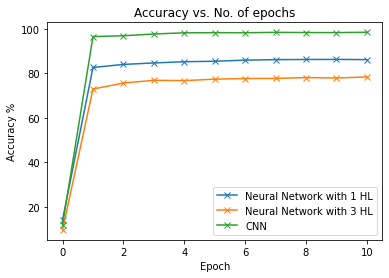

In [57]:
plt.plot(model_13.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_14.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_15.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [58]:
model_16 = torch.load('FC_1HL.pth')
model_16.acclist.append(validate(val_loader, model_16)*100)
start = time.perf_counter()
result_16 = fit(20, model_16, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_16)

Validation Error: 
 Accuracy: 14.2%, Avg loss: 0.023005 

Epoch 1
-------------------------------
loss: 2.290719  [    0/48000]
loss: 0.788333  [10000/48000]
loss: 0.573668  [20000/48000]
loss: 0.699212  [30000/48000]
loss: 0.538962  [40000/48000]
Validation Error: 
 Accuracy: 82.9%, Avg loss: 0.005454 

Epoch 2
-------------------------------
loss: 0.527539  [    0/48000]
loss: 0.697668  [10000/48000]
loss: 0.590042  [20000/48000]
loss: 0.297898  [30000/48000]
loss: 0.549359  [40000/48000]
Validation Error: 
 Accuracy: 84.1%, Avg loss: 0.004923 

Epoch 3
-------------------------------
loss: 0.311057  [    0/48000]
loss: 0.433381  [10000/48000]
loss: 0.435068  [20000/48000]
loss: 0.396081  [30000/48000]
loss: 0.348840  [40000/48000]
Validation Error: 
 Accuracy: 84.6%, Avg loss: 0.004659 

Epoch 4
-------------------------------
loss: 0.385409  [    0/48000]
loss: 0.286300  [10000/48000]
loss: 0.448552  [20000/48000]
loss: 0.440367  [30000/48000]
loss: 0.505708  [40000/48000]
Validati

In [59]:
model_17 = torch.load('FC_3HL.pth')
model_17.acclist.append(validate(val_loader, model_17)*100)
start = time.perf_counter()
result_17 = fit(20, model_17, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_17)

Validation Error: 
 Accuracy: 9.7%, Avg loss: 0.023031 

Epoch 1
-------------------------------
loss: 2.302908  [    0/48000]
loss: 2.121493  [10000/48000]
loss: 1.060837  [20000/48000]
loss: 1.231768  [30000/48000]
loss: 0.660692  [40000/48000]
Validation Error: 
 Accuracy: 72.6%, Avg loss: 0.008346 

Epoch 2
-------------------------------
loss: 0.968687  [    0/48000]
loss: 0.871278  [10000/48000]
loss: 0.828568  [20000/48000]
loss: 0.811535  [30000/48000]
loss: 0.607200  [40000/48000]
Validation Error: 
 Accuracy: 75.5%, Avg loss: 0.006885 

Epoch 3
-------------------------------
loss: 0.715094  [    0/48000]
loss: 0.519271  [10000/48000]
loss: 0.750880  [20000/48000]
loss: 0.782311  [30000/48000]
loss: 0.708109  [40000/48000]
Validation Error: 
 Accuracy: 76.6%, Avg loss: 0.006423 

Epoch 4
-------------------------------
loss: 0.611177  [    0/48000]
loss: 0.745023  [10000/48000]
loss: 0.604241  [20000/48000]
loss: 0.652417  [30000/48000]
loss: 0.686397  [40000/48000]
Validatio

In [60]:
model_18 = torch.load('CNN.pth')
model_18.acclist.append(validate(val_loader, model_18)*100)
start = time.perf_counter()
result_18 = fit(20, model_18, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_18)

Validation Error: 
 Accuracy: 12.0%, Avg loss: 0.023065 

Epoch 1
-------------------------------
loss: 2.301843  [    0/48000]
loss: 0.251161  [10000/48000]
loss: 0.240411  [20000/48000]
loss: 0.180682  [30000/48000]
loss: 0.179788  [40000/48000]
Validation Error: 
 Accuracy: 96.3%, Avg loss: 0.001287 

Epoch 2
-------------------------------
loss: 0.087100  [    0/48000]
loss: 0.142963  [10000/48000]
loss: 0.073744  [20000/48000]
loss: 0.095960  [30000/48000]
loss: 0.073514  [40000/48000]
Validation Error: 
 Accuracy: 96.8%, Avg loss: 0.001105 

Epoch 3
-------------------------------
loss: 0.098689  [    0/48000]
loss: 0.051012  [10000/48000]
loss: 0.137105  [20000/48000]
loss: 0.085936  [30000/48000]
loss: 0.076206  [40000/48000]
Validation Error: 
 Accuracy: 97.8%, Avg loss: 0.000768 

Epoch 4
-------------------------------
loss: 0.042912  [    0/48000]
loss: 0.063110  [10000/48000]
loss: 0.010607  [20000/48000]
loss: 0.052328  [30000/48000]
loss: 0.070626  [40000/48000]
Validati

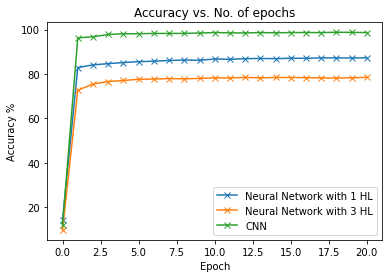

In [61]:
plt.plot(model_16.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_17.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_18.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [62]:
model_19 = torch.load('FC_1HL.pth')
model_19.acclist.append(validate(val_loader, model_19)*100)
start = time.perf_counter()
result_19 = fit2(10, model_19, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_19)

Validation Error: 
 Accuracy: 14.2%, Avg loss: 0.023005 

Epoch 1
-------------------------------
loss: 2.302365  [    0/48000]
loss: 0.829058  [10000/48000]
loss: 0.574614  [20000/48000]
loss: 0.704373  [30000/48000]
loss: 0.777685  [40000/48000]
Validation Error: 
 Accuracy: 68.0%, Avg loss: 0.008396 

Epoch 2
-------------------------------
loss: 0.688571  [    0/48000]
loss: 0.889931  [10000/48000]
loss: 0.882209  [20000/48000]
loss: 0.698637  [30000/48000]
loss: 0.786348  [40000/48000]
Validation Error: 
 Accuracy: 68.3%, Avg loss: 0.008082 

Epoch 3
-------------------------------
loss: 0.718977  [    0/48000]
loss: 0.684954  [10000/48000]
loss: 0.885527  [20000/48000]
loss: 0.896243  [30000/48000]
loss: 0.752109  [40000/48000]
Validation Error: 
 Accuracy: 68.3%, Avg loss: 0.008037 

Epoch 4
-------------------------------
loss: 0.758538  [    0/48000]
loss: 0.639491  [10000/48000]
loss: 0.880043  [20000/48000]
loss: 0.742501  [30000/48000]
loss: 1.010363  [40000/48000]
Validati

In [63]:
model_20 = torch.load('FC_3HL.pth')
model_20.acclist.append(validate(val_loader, model_20)*100)
start = time.perf_counter()
result_20 = fit2(10, model_20, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_20)

Validation Error: 
 Accuracy: 9.7%, Avg loss: 0.023031 

Epoch 1
-------------------------------
loss: 2.307509  [    0/48000]
loss: 1.628221  [10000/48000]
loss: 1.661630  [20000/48000]
loss: 1.685824  [30000/48000]
loss: 1.835058  [40000/48000]
Validation Error: 
 Accuracy: 28.4%, Avg loss: 0.017113 

Epoch 2
-------------------------------
loss: 1.496060  [    0/48000]
loss: 1.651065  [10000/48000]
loss: 1.462183  [20000/48000]
loss: 1.713910  [30000/48000]
loss: 1.544412  [40000/48000]
Validation Error: 
 Accuracy: 28.7%, Avg loss: 0.016933 

Epoch 3
-------------------------------
loss: 1.771549  [    0/48000]
loss: 1.573234  [10000/48000]
loss: 1.747937  [20000/48000]
loss: 1.729479  [30000/48000]
loss: 1.736524  [40000/48000]
Validation Error: 
 Accuracy: 28.4%, Avg loss: 0.016852 

Epoch 4
-------------------------------
loss: 1.695236  [    0/48000]
loss: 1.588638  [10000/48000]
loss: 1.774706  [20000/48000]
loss: 1.522883  [30000/48000]
loss: 1.575123  [40000/48000]
Validatio

In [64]:
model_21 = torch.load('CNN.pth')
model_21.acclist.append(validate(val_loader, model_21)*100)
start = time.perf_counter()
result_21 = fit2(10, model_21, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_21)

Validation Error: 
 Accuracy: 12.0%, Avg loss: 0.023065 

Epoch 1
-------------------------------
loss: 2.323045  [    0/48000]
loss: 0.230665  [10000/48000]
loss: 0.219782  [20000/48000]
loss: 0.099154  [30000/48000]
loss: 0.081599  [40000/48000]
Validation Error: 
 Accuracy: 97.8%, Avg loss: 0.000745 

Epoch 2
-------------------------------
loss: 0.065891  [    0/48000]
loss: 0.187400  [10000/48000]
loss: 0.011457  [20000/48000]
loss: 0.073401  [30000/48000]
loss: 0.235295  [40000/48000]
Validation Error: 
 Accuracy: 98.0%, Avg loss: 0.000640 

Epoch 3
-------------------------------
loss: 0.016286  [    0/48000]
loss: 0.047291  [10000/48000]
loss: 0.073446  [20000/48000]
loss: 0.073427  [30000/48000]
loss: 0.090639  [40000/48000]
Validation Error: 
 Accuracy: 98.1%, Avg loss: 0.000639 

Epoch 4
-------------------------------
loss: 0.028610  [    0/48000]
loss: 0.003506  [10000/48000]
loss: 0.066191  [20000/48000]
loss: 0.001447  [30000/48000]
loss: 0.008015  [40000/48000]
Validati

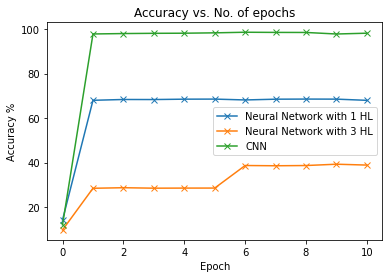

In [67]:
plt.plot(model_19.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_20.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_21.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [68]:
model_22 = torch.load('FC_1HL.pth')
model_22.acclist.append(validate(val_loader, model_22)*100)
start = time.perf_counter()
result_22 = fit2(20, model_22, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_22)

Validation Error: 
 Accuracy: 14.2%, Avg loss: 0.023005 

Epoch 1
-------------------------------
loss: 2.309722  [    0/48000]
loss: 0.536922  [10000/48000]
loss: 0.573656  [20000/48000]
loss: 0.514655  [30000/48000]
loss: 0.564968  [40000/48000]
Validation Error: 
 Accuracy: 77.0%, Avg loss: 0.006130 

Epoch 2
-------------------------------
loss: 0.529578  [    0/48000]
loss: 0.712758  [10000/48000]
loss: 0.396649  [20000/48000]
loss: 0.567763  [30000/48000]
loss: 0.726182  [40000/48000]
Validation Error: 
 Accuracy: 77.5%, Avg loss: 0.005920 

Epoch 3
-------------------------------
loss: 0.649085  [    0/48000]
loss: 0.500558  [10000/48000]
loss: 0.734039  [20000/48000]
loss: 0.512141  [30000/48000]
loss: 0.334383  [40000/48000]
Validation Error: 
 Accuracy: 77.3%, Avg loss: 0.005954 

Epoch 4
-------------------------------
loss: 0.517147  [    0/48000]
loss: 0.570397  [10000/48000]
loss: 0.457990  [20000/48000]
loss: 0.385620  [30000/48000]
loss: 0.621328  [40000/48000]
Validati

In [69]:
model_23 = torch.load('FC_3HL.pth')
model_23.acclist.append(validate(val_loader, model_23)*100)
start = time.perf_counter()
result_23 = fit2(20, model_23, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_23)

Validation Error: 
 Accuracy: 9.7%, Avg loss: 0.023031 

Epoch 1
-------------------------------
loss: 2.301007  [    0/48000]
loss: 1.161233  [10000/48000]
loss: 1.150521  [20000/48000]
loss: 1.572093  [30000/48000]
loss: 1.098492  [40000/48000]
Validation Error: 
 Accuracy: 49.9%, Avg loss: 0.012149 

Epoch 2
-------------------------------
loss: 1.216988  [    0/48000]
loss: 1.180027  [10000/48000]
loss: 1.270100  [20000/48000]
loss: 1.247883  [30000/48000]
loss: 1.255272  [40000/48000]
Validation Error: 
 Accuracy: 50.0%, Avg loss: 0.012144 

Epoch 3
-------------------------------
loss: 1.279160  [    0/48000]
loss: 1.137855  [10000/48000]
loss: 0.937842  [20000/48000]
loss: 1.271094  [30000/48000]
loss: 1.135428  [40000/48000]
Validation Error: 
 Accuracy: 50.3%, Avg loss: 0.012054 

Epoch 4
-------------------------------
loss: 1.063768  [    0/48000]
loss: 1.462281  [10000/48000]
loss: 1.226575  [20000/48000]
loss: 1.173002  [30000/48000]
loss: 1.058834  [40000/48000]
Validatio

In [70]:
model_24 = torch.load('CNN.pth')
model_24.acclist.append(validate(val_loader, model_24)*100)
start = time.perf_counter()
result_24 = fit2(20, model_24, train_loader, val_loader, loss_fn, 0.01)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_24)

Validation Error: 
 Accuracy: 12.0%, Avg loss: 0.023065 

Epoch 1
-------------------------------
loss: 2.291060  [    0/48000]
loss: 0.149138  [10000/48000]
loss: 0.042116  [20000/48000]
loss: 0.042047  [30000/48000]
loss: 0.126438  [40000/48000]
Validation Error: 
 Accuracy: 97.9%, Avg loss: 0.000690 

Epoch 2
-------------------------------
loss: 0.007165  [    0/48000]
loss: 0.027930  [10000/48000]
loss: 0.053367  [20000/48000]
loss: 0.093230  [30000/48000]
loss: 0.034087  [40000/48000]
Validation Error: 
 Accuracy: 98.4%, Avg loss: 0.000566 

Epoch 3
-------------------------------
loss: 0.040268  [    0/48000]
loss: 0.004041  [10000/48000]
loss: 0.008159  [20000/48000]
loss: 0.042885  [30000/48000]
loss: 0.050460  [40000/48000]
Validation Error: 
 Accuracy: 98.4%, Avg loss: 0.000528 

Epoch 4
-------------------------------
loss: 0.006139  [    0/48000]
loss: 0.106629  [10000/48000]
loss: 0.052399  [20000/48000]
loss: 0.072068  [30000/48000]
loss: 0.006700  [40000/48000]
Validati

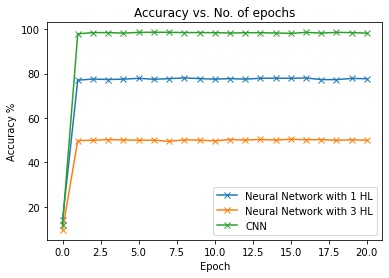

In [71]:
plt.plot(model_22.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_23.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_24.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [77]:
model_25 = torch.load('FC_1HL.pth')
model_25.acclist.append(validate(val_loader, model_25)*100)
start = time.perf_counter()
result_25 = fit2(10, model_25, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_25)

Validation Error: 
 Accuracy: 14.2%, Avg loss: 0.023005 

Epoch 1
-------------------------------
loss: 2.298090  [    0/48000]
loss: 1.620739  [10000/48000]
loss: 1.768699  [20000/48000]
loss: 1.754015  [30000/48000]
loss: 1.590827  [40000/48000]
Validation Error: 
 Accuracy: 37.9%, Avg loss: 0.015143 

Epoch 2
-------------------------------
loss: 1.404163  [    0/48000]
loss: 1.409652  [10000/48000]
loss: 1.454316  [20000/48000]
loss: 1.541810  [30000/48000]
loss: 1.537840  [40000/48000]
Validation Error: 
 Accuracy: 38.0%, Avg loss: 0.015034 

Epoch 3
-------------------------------
loss: 1.427200  [    0/48000]
loss: 1.533520  [10000/48000]
loss: 1.510418  [20000/48000]
loss: 1.391221  [30000/48000]
loss: 1.372412  [40000/48000]
Validation Error: 
 Accuracy: 37.6%, Avg loss: 0.015090 

Epoch 4
-------------------------------
loss: 1.533594  [    0/48000]
loss: 1.463100  [10000/48000]
loss: 1.594680  [20000/48000]
loss: 1.531441  [30000/48000]
loss: 1.462591  [40000/48000]
Validati

In [78]:
model_26 = torch.load('FC_3HL.pth')
model_26.acclist.append(validate(val_loader, model_26)*100)
start = time.perf_counter()
result_26 = fit2(10, model_26, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_26)

Validation Error: 
 Accuracy: 9.7%, Avg loss: 0.023031 

Epoch 1
-------------------------------
loss: 2.300029  [    0/48000]
loss: 2.176724  [10000/48000]
loss: 88.603516  [20000/48000]
loss: 2.141415  [30000/48000]
loss: 2.081919  [40000/48000]
Validation Error: 
 Accuracy: 20.9%, Avg loss: 0.020595 

Epoch 2
-------------------------------
loss: 2.105597  [    0/48000]
loss: 2.095357  [10000/48000]
loss: 2.026290  [20000/48000]
loss: 2.050787  [30000/48000]
loss: 2.054119  [40000/48000]
Validation Error: 
 Accuracy: 20.8%, Avg loss: 0.020689 

Epoch 3
-------------------------------
loss: 2.026273  [    0/48000]
loss: 2.150582  [10000/48000]
loss: 2.032203  [20000/48000]
loss: 2.034295  [30000/48000]
loss: 1.888141  [40000/48000]
Validation Error: 
 Accuracy: 21.0%, Avg loss: 0.020521 

Epoch 4
-------------------------------
loss: 2.050380  [    0/48000]
loss: 2.027747  [10000/48000]
loss: 1.985003  [20000/48000]
loss: 1.875310  [30000/48000]
loss: 1.888143  [40000/48000]
Validati

In [79]:
model_27 = torch.load('CNN.pth')
model_27.acclist.append(validate(val_loader, model_27)*100)
start = time.perf_counter()
result_27 = fit2(10, model_27, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_27)

Validation Error: 
 Accuracy: 12.0%, Avg loss: 0.023065 

Epoch 1
-------------------------------
loss: 2.313265  [    0/48000]
loss: 0.250753  [10000/48000]
loss: 0.109241  [20000/48000]
loss: 0.166463  [30000/48000]
loss: 0.084376  [40000/48000]
Validation Error: 
 Accuracy: 92.8%, Avg loss: 0.002185 

Epoch 2
-------------------------------
loss: 0.232840  [    0/48000]
loss: 0.149809  [10000/48000]
loss: 0.058296  [20000/48000]
loss: 0.218751  [30000/48000]
loss: 0.160375  [40000/48000]
Validation Error: 
 Accuracy: 96.0%, Avg loss: 0.001281 

Epoch 3
-------------------------------
loss: 0.157344  [    0/48000]
loss: 0.135037  [10000/48000]
loss: 0.058833  [20000/48000]
loss: 0.051450  [30000/48000]
loss: 0.281979  [40000/48000]
Validation Error: 
 Accuracy: 96.2%, Avg loss: 0.001362 

Epoch 4
-------------------------------
loss: 0.067088  [    0/48000]
loss: 0.014254  [10000/48000]
loss: 0.060571  [20000/48000]
loss: 0.127616  [30000/48000]
loss: 0.116690  [40000/48000]
Validati

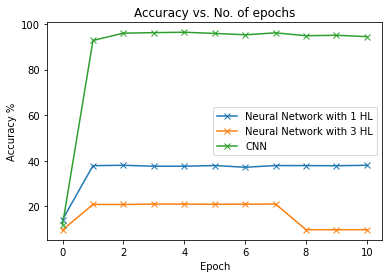

In [81]:
plt.plot(model_25.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_26.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_27.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [82]:
model_28 = torch.load('FC_1HL.pth')
model_28.acclist.append(validate(val_loader, model_28)*100)
start = time.perf_counter()
result_28 = fit2(20, model_28, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_28)

Validation Error: 
 Accuracy: 14.2%, Avg loss: 0.023005 

Epoch 1
-------------------------------
loss: 2.292566  [    0/48000]
loss: 1.775683  [10000/48000]
loss: 1.838978  [20000/48000]
loss: 1.454899  [30000/48000]
loss: 1.954613  [40000/48000]
Validation Error: 
 Accuracy: 31.4%, Avg loss: 0.018342 

Epoch 2
-------------------------------
loss: 1.787506  [    0/48000]
loss: 1.888589  [10000/48000]
loss: 1.884948  [20000/48000]
loss: 1.942080  [30000/48000]
loss: 1.857259  [40000/48000]
Validation Error: 
 Accuracy: 31.0%, Avg loss: 0.018386 

Epoch 3
-------------------------------
loss: 1.848861  [    0/48000]
loss: 1.862071  [10000/48000]
loss: 1.987914  [20000/48000]
loss: 1.779399  [30000/48000]
loss: 1.807836  [40000/48000]
Validation Error: 
 Accuracy: 30.8%, Avg loss: 0.018373 

Epoch 4
-------------------------------
loss: 1.934435  [    0/48000]
loss: 1.934353  [10000/48000]
loss: 1.878774  [20000/48000]
loss: 1.959770  [30000/48000]
loss: 1.730405  [40000/48000]
Validati

In [83]:
model_29 = torch.load('FC_3HL.pth')
model_29.acclist.append(validate(val_loader, model_29)*100)
start = time.perf_counter()
result_29 = fit2(20, model_29, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_29)

Validation Error: 
 Accuracy: 9.7%, Avg loss: 0.023031 

Epoch 1
-------------------------------
loss: 2.305987  [    0/48000]
loss: 2.072326  [10000/48000]
loss: 2.049299  [20000/48000]
loss: 1.981689  [30000/48000]
loss: 2.159403  [40000/48000]
Validation Error: 
 Accuracy: 21.0%, Avg loss: 0.020515 

Epoch 2
-------------------------------
loss: 2.049443  [    0/48000]
loss: 2.074296  [10000/48000]
loss: 2.027149  [20000/48000]
loss: 2.035152  [30000/48000]
loss: 2.073850  [40000/48000]
Validation Error: 
 Accuracy: 20.9%, Avg loss: 0.020527 

Epoch 3
-------------------------------
loss: 2.151465  [    0/48000]
loss: 2.055120  [10000/48000]
loss: 1.960643  [20000/48000]
loss: 2.075116  [30000/48000]
loss: 2.100877  [40000/48000]
Validation Error: 
 Accuracy: 21.0%, Avg loss: 0.020510 

Epoch 4
-------------------------------
loss: 1.957391  [    0/48000]
loss: 2.164428  [10000/48000]
loss: 2.141408  [20000/48000]
loss: 2.009144  [30000/48000]
loss: 2.187454  [40000/48000]
Validatio

In [84]:
model_30 = torch.load('CNN.pth')
model_30.acclist.append(validate(val_loader, model_30)*100)
start = time.perf_counter()
result_30 = fit2(20, model_30, train_loader, val_loader, loss_fn, 0.05)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_30)

Validation Error: 
 Accuracy: 12.0%, Avg loss: 0.023065 

Epoch 1
-------------------------------
loss: 2.305132  [    0/48000]
loss: 2.304727  [10000/48000]
loss: 2.292029  [20000/48000]
loss: 2.295475  [30000/48000]
loss: 2.317276  [40000/48000]
Validation Error: 
 Accuracy: 11.5%, Avg loss: 0.023047 

Epoch 2
-------------------------------
loss: 2.311272  [    0/48000]
loss: 2.314116  [10000/48000]
loss: 2.298955  [20000/48000]
loss: 2.303239  [30000/48000]
loss: 2.291505  [40000/48000]
Validation Error: 
 Accuracy: 9.7%, Avg loss: 0.023059 

Epoch 3
-------------------------------
loss: 2.300007  [    0/48000]
loss: 2.292729  [10000/48000]
loss: 2.314189  [20000/48000]
loss: 2.304164  [30000/48000]
loss: 2.297733  [40000/48000]
Validation Error: 
 Accuracy: 10.2%, Avg loss: 0.023055 

Epoch 4
-------------------------------
loss: 2.312578  [    0/48000]
loss: 2.313828  [10000/48000]
loss: 2.317686  [20000/48000]
loss: 2.319060  [30000/48000]
loss: 2.314678  [40000/48000]
Validatio

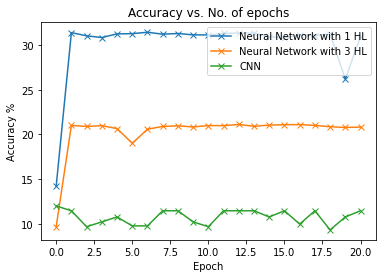

In [85]:
plt.plot(model_28.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_29.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_30.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [88]:
model_31 = torch.load('FC_1HL.pth')
model_31.acclist.append(validate(val_loader, model_31)*100)
start = time.perf_counter()
result_31 = fit2(10, model_31, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_31)

Validation Error: 
 Accuracy: 14.2%, Avg loss: 0.023005 

Epoch 1
-------------------------------
loss: 2.292076  [    0/48000]
loss: 1.981501  [10000/48000]
loss: 1.770655  [20000/48000]
loss: 1.756711  [30000/48000]
loss: 1.709323  [40000/48000]
Validation Error: 
 Accuracy: 30.9%, Avg loss: 0.018600 

Epoch 2
-------------------------------
loss: 1.951273  [    0/48000]
loss: 1.840436  [10000/48000]
loss: 1.700864  [20000/48000]
loss: 1.922254  [30000/48000]
loss: 1.580672  [40000/48000]
Validation Error: 
 Accuracy: 36.3%, Avg loss: 0.017518 

Epoch 3
-------------------------------
loss: 1.635873  [    0/48000]
loss: 1.590870  [10000/48000]
loss: 1.649667  [20000/48000]
loss: 1.601480  [30000/48000]
loss: 1.859345  [40000/48000]
Validation Error: 
 Accuracy: 30.6%, Avg loss: 0.018555 

Epoch 4
-------------------------------
loss: 1.843434  [    0/48000]
loss: 1.858578  [10000/48000]
loss: 2.002938  [20000/48000]
loss: 1.753924  [30000/48000]
loss: 1.872906  [40000/48000]
Validati

In [89]:
model_32 = torch.load('FC_3HL.pth')
model_32.acclist.append(validate(val_loader, model_32)*100)
start = time.perf_counter()
result_32 = fit2(10, model_32, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_32)

Validation Error: 
 Accuracy: 9.7%, Avg loss: 0.023031 

Epoch 1
-------------------------------
loss: 2.299945  [    0/48000]
loss: 2.049474  [10000/48000]
loss: 2.302583  [20000/48000]
loss: 2.302583  [30000/48000]
loss: 2.302583  [40000/48000]
Validation Error: 
 Accuracy: 9.8%, Avg loss: 0.023026 

Epoch 2
-------------------------------
loss: 2.302583  [    0/48000]
loss: 2.302583  [10000/48000]
loss: 2.302583  [20000/48000]
loss: 2.302583  [30000/48000]
loss: 2.302583  [40000/48000]
Validation Error: 
 Accuracy: 9.8%, Avg loss: 0.023026 

Epoch 3
-------------------------------
loss: 2.302583  [    0/48000]
loss: 2.302583  [10000/48000]
loss: 2.302583  [20000/48000]
loss: 2.302583  [30000/48000]
loss: 2.302583  [40000/48000]
Validation Error: 
 Accuracy: 9.8%, Avg loss: 0.023026 

Epoch 4
-------------------------------
loss: 2.302583  [    0/48000]
loss: 2.302583  [10000/48000]
loss: 2.302583  [20000/48000]
loss: 2.302583  [30000/48000]
loss: 2.302583  [40000/48000]
Validation E

In [90]:
model_33 = torch.load('CNN.pth')
model_33.acclist.append(validate(val_loader, model_33)*100)
start = time.perf_counter()
result_33 = fit2(10, model_33, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_33)

Validation Error: 
 Accuracy: 12.0%, Avg loss: 0.023065 

Epoch 1
-------------------------------
loss: 2.296847  [    0/48000]
loss: 2.314769  [10000/48000]
loss: 2.301450  [20000/48000]
loss: 2.300462  [30000/48000]
loss: 2.306921  [40000/48000]
Validation Error: 
 Accuracy: 11.5%, Avg loss: 0.023107 

Epoch 2
-------------------------------
loss: 2.279046  [    0/48000]
loss: 2.312634  [10000/48000]
loss: 2.295343  [20000/48000]
loss: 2.298170  [30000/48000]
loss: 2.292698  [40000/48000]
Validation Error: 
 Accuracy: 9.7%, Avg loss: 0.023096 

Epoch 3
-------------------------------
loss: 2.313779  [    0/48000]
loss: 2.320367  [10000/48000]
loss: 2.327533  [20000/48000]
loss: 2.309564  [30000/48000]
loss: 2.290008  [40000/48000]
Validation Error: 
 Accuracy: 9.8%, Avg loss: 0.023093 

Epoch 4
-------------------------------
loss: 2.315433  [    0/48000]
loss: 2.307380  [10000/48000]
loss: 2.298586  [20000/48000]
loss: 2.304187  [30000/48000]
loss: 2.323026  [40000/48000]
Validation

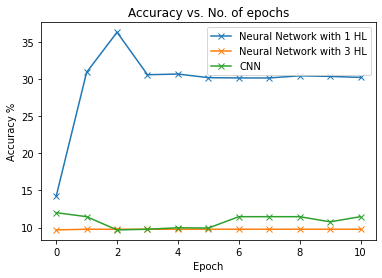

In [91]:
plt.plot(model_31.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_32.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_33.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()

# -----------------------------------------------------------------------------------------

In [95]:
model_34 = torch.load('FC_1HL.pth')
model_34.acclist.append(validate(val_loader, model_34)*100)
start = time.perf_counter()
result_34 = fit2(20, model_34, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_34)

Validation Error: 
 Accuracy: 14.2%, Avg loss: 0.023005 

Epoch 1
-------------------------------
loss: 2.300197  [    0/48000]
loss: 2.141402  [10000/48000]
loss: 2.117487  [20000/48000]
loss: 2.140579  [30000/48000]
loss: 1.980221  [40000/48000]
Validation Error: 
 Accuracy: 20.8%, Avg loss: 0.020627 

Epoch 2
-------------------------------
loss: 2.049300  [    0/48000]
loss: 2.170709  [10000/48000]
loss: 2.256531  [20000/48000]
loss: 2.072325  [30000/48000]
loss: 2.099413  [40000/48000]
Validation Error: 
 Accuracy: 20.5%, Avg loss: 0.020616 

Epoch 3
-------------------------------
loss: 2.072325  [    0/48000]
loss: 2.025765  [10000/48000]
loss: 2.095351  [20000/48000]
loss: 2.003247  [30000/48000]
loss: 2.072335  [40000/48000]
Validation Error: 
 Accuracy: 20.8%, Avg loss: 0.020749 

Epoch 4
-------------------------------
loss: 2.233505  [    0/48000]
loss: 2.027299  [10000/48000]
loss: 2.049299  [20000/48000]
loss: 2.095351  [30000/48000]
loss: 1.906909  [40000/48000]
Validati

In [96]:
model_35 = torch.load('FC_3HL.pth')
model_35.acclist.append(validate(val_loader, model_35)*100)
start = time.perf_counter()
result_35 = fit2(20, model_35, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_35)

Validation Error: 
 Accuracy: 9.7%, Avg loss: 0.023031 

Epoch 1
-------------------------------
loss: 2.303140  [    0/48000]
loss: 2.302583  [10000/48000]
loss: 2.302583  [20000/48000]
loss: 2.302583  [30000/48000]
loss: 2.302583  [40000/48000]
Validation Error: 
 Accuracy: 9.8%, Avg loss: 0.023026 

Epoch 2
-------------------------------
loss: 2.302583  [    0/48000]
loss: 2.302583  [10000/48000]
loss: 2.302583  [20000/48000]
loss: 2.302583  [30000/48000]
loss: 2.302583  [40000/48000]
Validation Error: 
 Accuracy: 9.8%, Avg loss: 0.023026 

Epoch 3
-------------------------------
loss: 2.302583  [    0/48000]
loss: 2.302583  [10000/48000]
loss: 2.302583  [20000/48000]
loss: 2.302583  [30000/48000]
loss: 2.302583  [40000/48000]
Validation Error: 
 Accuracy: 9.8%, Avg loss: 0.023026 

Epoch 4
-------------------------------
loss: 2.302583  [    0/48000]
loss: 2.302583  [10000/48000]
loss: 2.302583  [20000/48000]
loss: 2.302583  [30000/48000]
loss: 2.302583  [40000/48000]
Validation E

In [97]:
model_36 = torch.load('CNN.pth')
model_36.acclist.append(validate(val_loader, model_36)*100)
start = time.perf_counter()
result_36 = fit2(20, model_36, train_loader, val_loader, loss_fn, 0.1)
end = time.perf_counter()
print(f"Training completed in {end - start:0.2f} seconds")

test_loader = DataLoader(test_dataset, batch_size=100)
result = validate(test_loader, model_36)

Validation Error: 
 Accuracy: 12.0%, Avg loss: 0.023065 

Epoch 1
-------------------------------
loss: 2.294347  [    0/48000]
loss: 0.602191  [10000/48000]
loss: 0.302054  [20000/48000]
loss: 0.199739  [30000/48000]
loss: 0.194442  [40000/48000]
Validation Error: 
 Accuracy: 92.8%, Avg loss: 0.002420 

Epoch 2
-------------------------------
loss: 0.155424  [    0/48000]
loss: 0.234324  [10000/48000]
loss: 0.361606  [20000/48000]
loss: 0.223557  [30000/48000]
loss: 0.305499  [40000/48000]
Validation Error: 
 Accuracy: 93.4%, Avg loss: 0.002125 

Epoch 3
-------------------------------
loss: 0.217833  [    0/48000]
loss: 0.175953  [10000/48000]
loss: 0.272863  [20000/48000]
loss: 0.280716  [30000/48000]
loss: 0.047455  [40000/48000]
Validation Error: 
 Accuracy: 93.3%, Avg loss: 0.002114 

Epoch 4
-------------------------------
loss: 0.144909  [    0/48000]
loss: 0.161222  [10000/48000]
loss: 0.248639  [20000/48000]
loss: 0.281764  [30000/48000]
loss: 0.144161  [40000/48000]
Validati

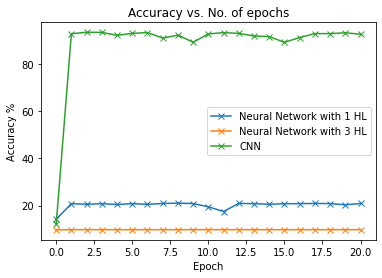

In [99]:
plt.plot(model_34.acclist, '-x', label='Neural Network with 1 HL')
plt.plot(model_35.acclist, '-x', label='Neural Network with 3 HL')
plt.plot(model_36.acclist, '-x', label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.title('Accuracy vs. No. of epochs');
plt.legend()